In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B,TNC
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
import numpy as np
import matplotlib.pyplot as plt
import time, copy, warnings

import torch
import torchvision

from torchvision import datasets, transforms

from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from qiskit_algorithms.utils import algorithm_globals
np.random.seed(42)
algorithm_globals.random_seed = 12345


## Some additional Functions

In [3]:
### Printing parameters of model
# Assuming 'model' is your fully connected model
def print_model_parameters(model):
    """
    Print the parameters (weights and biases) of the fully connected model.

    Args:
        model (FCL): The fully connected model.
    """
    # Access the linear layer of the model
    linear_layer = model.fc
    
    # Print weights and biases
    print("Weights:")
    print(linear_layer.weight.data)
    print("Biases:")
    print(linear_layer.bias.data)

# Assuming 'model' is your fully connected model
# You need to instantiate the model before printing its parameters
# model = FCL(2**num_qubits, 2)  # You need to define input_size and output_size here
# # Train the model...
# # After training, call the print_model_parameters function
# print_model_parameters(model)


### Loss function

In [5]:
def cross_entropy(y_pred, y_true):
    # Convert y_pred and y_true to PyTorch tensors
    y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
    y_true_tensor = torch.tensor(y_true, dtype=torch.float32)

    # Ensure y_pred_tensor has the shape of y_true_tensor
    if y_pred_tensor.shape != y_true_tensor.shape:
        raise ValueError("Shapes of y_pred and y_true must match.")
    # Compute softmax values for predicted probabilities
    # y_pred_softmax = torch.softmax(y_pred_tensor, dim=-1)
    y_true_softmax = torch.softmax(y_true_tensor, dim=-1)

    # Compute cross-entropy loss
    loss = -torch.sum(y_true_softmax * torch.log(y_pred_tensor + 1e-10))
    # print(loss)
    return loss.item()

### Data Loading

In [7]:
# Load MNIST dataset
def load_dataset(size,train=True):
    root = '~/Documents/image_datasets/MNIST'
    dataset = datasets.MNIST(root=root, train=train, download=True,
                             transform=transforms.Compose([
                                 transforms.Resize((size, size)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=(0.5,), std=(0.5,))
                             ]))
    return dataset


size = 4
trainset = load_dataset(train=True,size=size)
testset = load_dataset(train=False,size=size)



### Selecting specific digits 

In [9]:
# Generate subset from dataset
def generate_subset(dataset, *classes):
    class_indices = torch.cat([torch.where(dataset.targets == c)[0] for c in classes])
    subset = torch.utils.data.Subset(dataset, class_indices)
    X = np.array([image.flatten().numpy() for image, _ in subset])
    y = np.array([label for _, label in subset])
    return X, y




# 
classes = [0, 1]
X_train, y_train = generate_subset(trainset, *classes)
X_test, y_test = generate_subset(testset, *classes)

# # Randomly sample a subset of data (optional)
# # random_indices_test = np.random.choice(range(len(X_test)), 100, replace=False)
# # X_test, y_test = X_test[random_indices_test], y_test[random_indices_test]

# # random_indices_train = np.random.choice(range(len(X_train)), 1000, replace=False)
# # X_train, y_train = X_train[random_indices_train], y_train[random_indices_train]

### One hot Encoding

In [11]:
def one_hot_encode(values):
    max_value = max(values)
    num_classes = max_value + 1
    one_hot_vectors = []
    for value in values:
        one_hot_vector = [0] * num_classes
        one_hot_vector[value] = 1
        one_hot_vectors.append(one_hot_vector)
    return one_hot_vectors

# Example usage:
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)



In [12]:
# size of the test and train set
print(f'Size of Training set is  {X_train.shape} \n and Testing set is {X_test.shape}')

Size of Training set is  (12665, 16) 
 and Testing set is (2115, 16)


### Creating a feature Map

In [14]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
import numpy as np

def create_feature_map(size, encoding):
    """
    Creates a feature map circuit based on the specified encoding type.

    Parameters:
        size (int): The size of the features.
        encoding (str): The encoding type. Choose from 'Pauli', 'Z', 'ZZ', or 'RawFeatureVector'.

    Returns:
        qiskit.QuantumCircuit: The feature map quantum circuit.
    """

    num_features = size ** 2
    num_qubits = num_features

    if encoding == 'Pauli':
        fm = PauliFeatureMap(feature_dimension=num_features, reps=1, paulis=['Z'])
    elif encoding == 'Z':
        fm = ZFeatureMap(feature_dimension=num_features, reps=1)
    elif encoding == 'ZZ':
        fm = ZZFeatureMap(feature_dimension=num_features, reps=1)
    elif encoding == 'RawFeatureVector':
        num_qubits = int(np.log2(num_features))
        fm = RawFeatureVector(feature_dimension=num_features)
    else:
        raise ValueError("Invalid encoding type. Choose from 'Pauli', 'Z', 'ZZ', or 'RawFeatureVector'.")

    # print(f'number of (features, qubits) = {num_features, num_qubits}')

    return fm, num_qubits

# Example usage:
encoding = 'RawFeatureVector'
fm,num_qubits = create_feature_map(size, encoding)
fm.draw()


»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                ├
«     │                                                                                                                 │
«q_1: ┤1                                                                                                                ├
«     │  Parameterizedinitialize(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15]) │
«q_2: ┤2                                                                                                                ├
«     │                                                                                                                 │
«q_3: ┤3                                                                                                                ├
«     └─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

### Creating Ansatz/ PQC

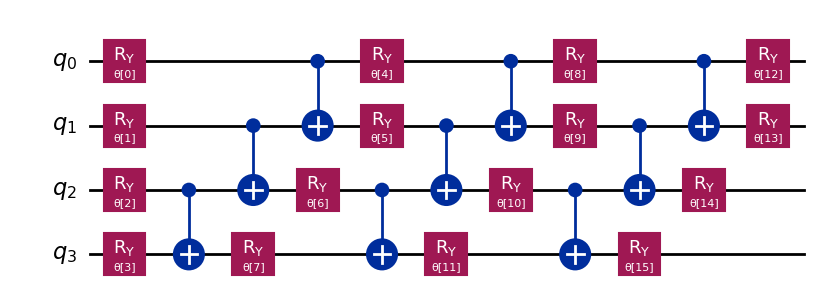

In [16]:
from qiskit.circuit.library import RealAmplitudes


ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)
ansatz.decompose().draw('mpl')

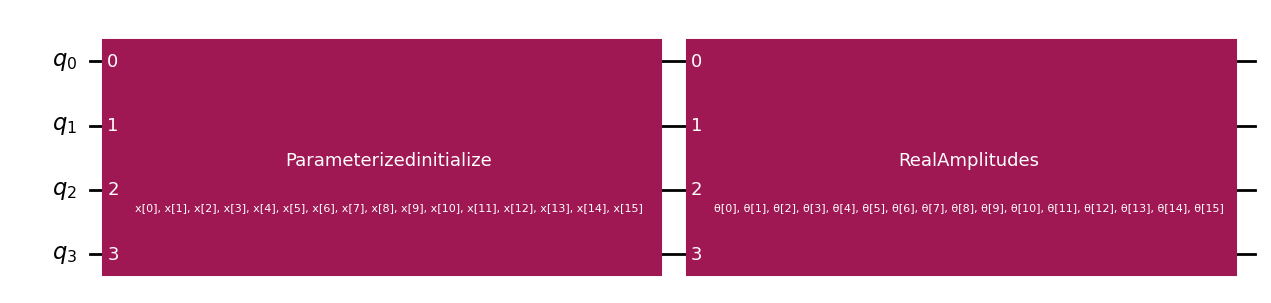

In [34]:
vqc_ckt = fm.compose(ansatz)
# vqc_ckt=vqc_ckt.compose(fm)
vqc_ckt.draw('mpl')

In [31]:
vqc_ckt.parameters

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5]), ParameterVectorElement(x[6]), ParameterVectorElement(x[7]), ParameterVectorElement(x[8]), ParameterVectorElement(x[9]), ParameterVectorElement(x[10]), ParameterVectorElement(x[11]), ParameterVectorElement(x[12]), ParameterVectorElement(x[13]), ParameterVectorElement(x[14]), ParameterVectorElement(x[15]), ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15])])

### Sampler and Inital Guess which is randomly Initialized

In [18]:
from qiskit.primitives import Estimator, Sampler
#estimator = Estimator()
sampler=Sampler()
x0 = np.random.rand(ansatz.num_parameters)
x0

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
       0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
       0.18340451])

### Take an example as input and feeds it to the quantum network output Quasi Distribution

In [21]:
def run_vqc_for_feature(vqc_ckt, sampler, params, feature):
    """
    Run a variational quantum circuit (VQC) for a given features of a datapoint.

    Args:
        vqc_ckt (QuantumCircuit): The variational quantum circuit.
        sampler (Sampler): The sampler object for executing the circuit.
        params (list): The parameters of the circuit.
        feature (list): The feature values.

    Returns:
        list: Quasi-probability distribution obtained from the circuit.
    """
    qc = vqc_ckt.copy()  # Create a copy of the variational quantum circuit
    parameters = list(feature) + list(params)  # Concatenate the feature with the circuit parameters
    qc.measure_all()  # Measure all qubits in the circuit
    job = sampler.run(qc, parameters)  # Run the circuit with the specified parameters
    res = job.result().quasi_dists  # Get the quasi-probability distributions from the result
    return list(res[0].values())  # Extract the quasi-probability distribution for the first outcome

# Example usage:
# for i, feature in enumerate(training_features):
#     dis = run_vqc_for_feature(vqc_ckt, sampler, params, feature)
    # Process the quasi-probability distribution obtained from the VQC for the current feature
    # (e.g., use it to update model parameters, compute loss, etc.)


### Defining a NN to see map $2^n$ to d classes


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCL(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCL, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x

# # Example usage:
# input_size = 2**n  # Size of the input vector
# output_size = d    # Size of the output vector

# # Initialize the model
# model = FCL(input_size, output_size)

# # Assuming your input_vector is a tensor of shape (batch_size, 2**n)
# # output_vector will be a tensor of shape (batch_size, d)
# output_vector = model(input_vector)


### Training of the Hybrid Network

In [25]:
# Fully connected network
input_size = 2 ** num_qubits  # Size of the input vector (output states of QC)
output_size = 2  # Size of the output vector (number of classes)
model = FCL(input_size, output_size)
f_val = []
itr = 0
def train_quantum_nn(x0,X_train, y_train, sampler, feature_map, ansatz, num_qubits):
    global f_val
    global itr 
    fm,num_qubits = create_feature_map(size, encoding)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)

    vqc_ckt = fm.compose(ansatz)

    loss = []
    for i, feature in enumerate(X_train):
        # Run the variational quantum circuit for the current feature
        dis = run_vqc_for_feature(vqc_ckt, sampler, x0, feature)
        dis_tensor = torch.tensor(dis, dtype=torch.float32)
        # apply sigmoid on dis_tensor

        y_true = np.zeros(2**num_qubits)
        if y_train[i][0]>y_train[i][1]:
            for j in range(len(y_true)):
                if j%2==0:
                    y_true[j] = 1
        else:
            for j in range(len(y_true)):
                if j%2!=0:
                    y_true[j] = 1
            # y_true[1] = 1
        # Predict using the fully connected network
        # y_predicted = model(dis_tensor)
        # y_predicted_numpy = y_predicted.detach().numpy()
        # Compute and append the cross-entropy loss
        loss.append(cross_entropy(dis_tensor.detach().numpy(),y_true))

    # Compute the average loss
    cost = sum(loss) / len(loss)
    f_val.append(cost)

    # Display progress every 2 iterations
    
    print('Iteration:', itr, 'fun:', cost)

    itr += 1

    return cost


In [26]:
# classical parameters before trainig
print_model_parameters(model)

Weights:
tensor([[ 0.1313,  0.1315,  0.2387, -0.1118, -0.2324, -0.1811, -0.2091, -0.0627,
         -0.1967, -0.2068, -0.2494, -0.2025,  0.0304,  0.1707,  0.1125,  0.1611],
        [-0.1719,  0.0688,  0.1083, -0.0115, -0.0823, -0.0539,  0.1213, -0.1986,
         -0.1207, -0.1930, -0.1577, -0.0270,  0.0127, -0.0692,  0.0281, -0.1414]])
Biases:
tensor([-0.1212,  0.1949])


### Training

In [ ]:
from scipy.optimize import minimize
opt_result = minimize(train_quantum_nn, x0, args=(X_train, y_train, sampler, fm, ansatz, num_qubits), method="COBYLA", options={'disp': True, 'ftol': 0.05, 'maxiter': 50})


In [28]:
# classical parameters after training
print_model_parameters(model)

Weights:
tensor([[ 0.1313,  0.1315,  0.2387, -0.1118, -0.2324, -0.1811, -0.2091, -0.0627,
         -0.1967, -0.2068, -0.2494, -0.2025,  0.0304,  0.1707,  0.1125,  0.1611],
        [-0.1719,  0.0688,  0.1083, -0.0115, -0.0823, -0.0539,  0.1213, -0.1986,
         -0.1207, -0.1930, -0.1577, -0.0270,  0.0127, -0.0692,  0.0281, -0.1414]])
Biases:
tensor([-0.1212,  0.1949])


### Evaluate the model accuracy

In [ ]:

def evaluate_model(X_test, y_test, sampler, feature_map, ansatz, num_qubits, trained_params):
    """
    Evaluate the quantum neural network on the test set.

    Args:
        X_test (numpy.ndarray): Test features.
        y_test (numpy.ndarray): True labels for the test set.
        sampler (Sampler): The sampler object for executing the circuit.
        feature_map (QuantumCircuit): Feature map circuit.
        ansatz (QuantumCircuit): Ansatz circuit.
        num_qubits (int): Number of qubits.
        trained_params (numpy.ndarray): Trained parameters for the quantum neural network.

    Returns:
        float: Accuracy of the model on the test set.
    """
    correct = 0
    total = len(X_test)

    vqc_ckt = feature_map.compose(ansatz)
    predictions=[]
    for i, feature in enumerate(X_test):
        # Run the variational quantum circuit for the current feature
        dis = run_vqc_for_feature(vqc_ckt, sampler, trained_params, feature)
        dis_tensor = torch.tensor(dis, dtype=torch.float32)
        # print(dis_tensor)
        # print(dis_tensor)
        # Predict using the fully connected network
        y_predicted = model(dis_tensor)
        # print(y_predicted.data)
        cl0=0
        cl1=0
        for j in range(len(dis_tensor)):
            if j%2==0:
                cl0+=dis_tensor[j]
            else:
                cl1+=dis_tensor[j]
        print(f'class0={cl0},class1={cl1}')
        predicted= 1 if cl1>cl0 else 0
        # predicted = torch.argmax(dis_tensor)
        predictions.append(predicted)
        # print(cl)
        # print(torch.argmax(torch.tensor(y_test[i])))
        # _, predicted = torch.max(y_predicted.data)
        
        # Check prediction accuracy
        if predicted == torch.argmax(torch.tensor(y_test[i])):
            correct += 1
    print(predictions)
    accuracy = correct / total
    return accuracy

# Assuming opt_result.x contains the optimized parameters
accuracy = evaluate_model(X_test, y_test, sampler, fm, ansatz, num_qubits, opt_result.x)
print("Accuracy on test set:", accuracy)
